# Online learning in the Lorenz 96 framework

This notebooks contains all the experiments and figures for the online learning paper. 

In [1]:
%load_ext autoreload
%autoreload 2

In [84]:
from L96 import *
from collections import deque
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
# Run this if you are using a GPU. Otherwise TF will use all your GPU memory...
# config = tf.ConfigProto()
# config.gpu_options.allow_growth=True
# sess = tf.Session(config=config)

In [74]:
# To make nice figures
sns.set_style('whitegrid')
sns.set_context('talk')
mpl.rcParams['figure.figsize'] = (7,5)
mpl.rcParams['lines.linewidth'] = 3

In [6]:
# Load initial conditions for L96 model
initX, initY = np.load('./data/initX.npy'), np.load('./data/initY.npy')
np.random.seed(123)

## Reference/"true" linear regression and neural network

First, we will fit a linear regression and a neural network to a reference dataset created using the true parameters of the system.

In [7]:
# Create a Lorenz 96 two-level object and run for 50 time units
l96_ref = L96TwoLevel(X_init=initX, Y_init=initY, save_dt=0.001)
l96_ref.iterate(50)

In [8]:
h = l96_ref.history   # xarray file

In [9]:
features = np.ravel(h.X.values)
targets = np.ravel(h.B.values)

In [10]:
features.shape, targets.shape

((1800036,), (1800036,))

### Linear regression

Fit a linear regression (a.k.a. a first order polynomial). These are our "true" parameters for linear regression

In [12]:
slope, intercept = np.polyfit(np.ravel(h.X.values), np.ravel(h.B.values), 1)
slope, intercept

(-0.3112771601245248, -0.19973845623403683)

### Neural network

Here, we will use a pretty simple neural network which is quite sufficient for the L96 parameterization task.

In [22]:
true_nn = keras.models.Sequential([
    Dense(32, input_shape=(1,), activation='elu'),
    Dense(32, activation='elu'),
    Dense(1)
])

In [23]:
true_nn.compile('adam', 'mse')

In [24]:
true_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Should take around half a minute
true_nn.fit(features, targets, epochs=2, verbose=1, batch_size=1024);

Epoch 1/2
1800036/1800036 [==============================] - 11s 6us/sample - loss: 0.2843
Epoch 2/2
1800036/1800036 [==============================] - 12s 7us/sample - loss: 0.2840


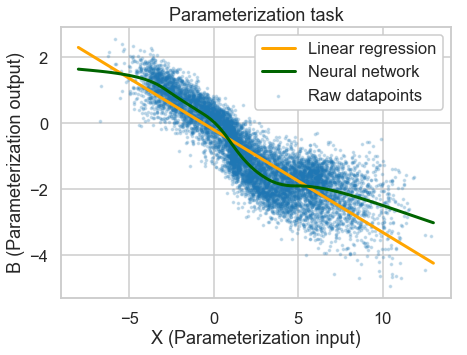

In [42]:
plt.scatter(features[::200], targets[::200], s=5, alpha=0.2, label='Raw datapoints');
plt.xlabel('X (Parameterization input)')
plt.ylabel('B (Parameterization output)')
plt.title('Parameterization task')
a = np.linspace(-8, 13, 100)
plt.plot(a, np.polyval((slope, intercept), a), label='Linear regression', c='orange')
plt.plot(a, true_nn.predict(a), label='Neural network', c='darkgreen')
plt.legend(framealpha=1);
#plt.savefig('figures/X-B-True.pdf', bbox_inches='tight')

## Create "wrong" linear regression with Keras

For online learning we assume that we do not have to completely start from scratch. We can always learn in a supervised manner, e.g. from a traditional parameterization or a coarse grained dataset.

To emulate this "starting point" in the L96 setup, we will run a simulation with "wrong" parameters and use this simulation to train out initial machine learning methods.

In [43]:
l96_wrong = L96TwoLevel(
    X_init=initX, Y_init=initY, 
    F=7,   # default = 10
    h=2,   # default = 1
    c=5,   # default = 10
    b=5    # default = 10
)

In [44]:
l96_wrong.iterate(20)

In [45]:
features_wrong = np.ravel(l96_wrong.history.X.values)
targets_wrong = np.ravel(l96_wrong.history.B.values)

In [46]:
features_wrong.shape

(7236,)

In [47]:
slope_wrong, intercept_wrong = np.polyfit(features_wrong, targets_wrong, 1)
slope_wrong, intercept_wrong

(-0.7482297839541219, -0.38580039259452187)

In [55]:
wrong_nn = keras.models.Sequential([
    Dense(32, input_shape=(1,), activation='elu'),
    Dense(32, activation='elu'),
    Dense(1)
])

In [56]:
wrong_nn.compile('adam', 'mse')

In [57]:
# Should take around half a minute
wrong_nn.fit(features_wrong, targets_wrong, epochs=30, verbose=0);

Epoch 1/30
7236/7236 [==============================] - 1s 158us/sample - loss: 1.5644
Epoch 2/30
7236/7236 [==============================] - 0s 51us/sample - loss: 0.9300
Epoch 3/30
7236/7236 [==============================] - 0s 52us/sample - loss: 0.9196
Epoch 4/30
7236/7236 [==============================] - 0s 54us/sample - loss: 0.9017
Epoch 5/30
7236/7236 [==============================] - 0s 57us/sample - loss: 0.8815
Epoch 6/30
7236/7236 [==============================] - 0s 56us/sample - loss: 0.8637
Epoch 7/30
7236/7236 [==============================] - 0s 54us/sample - loss: 0.8385
Epoch 8/30
7236/7236 [==============================] - 0s 56us/sample - loss: 0.8110
Epoch 9/30
7236/7236 [==============================] - 0s 52us/sample - loss: 0.7828
Epoch 10/30
7236/7236 [==============================] - 0s 54us/sample - loss: 0.7657
Epoch 11/30
7236/7236 [==============================] - 0s 55us/sample - loss: 0.7451
Epoch 12/30
7236/7236 [============================

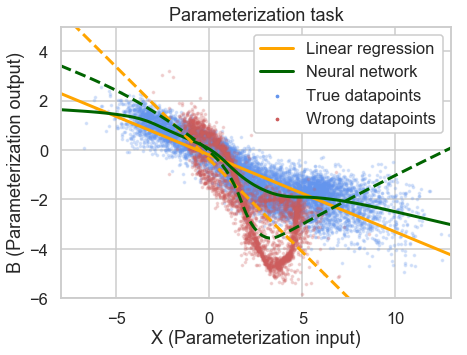

In [75]:
plt.scatter(features[::200], targets[::200], s=5, alpha=0.2, color='cornflowerblue');
plt.scatter(features_wrong[::2], targets_wrong[::2], s=5, alpha=0.2, color='indianred');
plt.scatter([999], [999], s=5, label='True datapoints', color='cornflowerblue')
plt.scatter([999], [999], s=5, label='Wrong datapoints', color='indianred')
plt.xlabel('X (Parameterization input)')
plt.ylabel('B (Parameterization output)')
plt.title('Parameterization task')
a = np.linspace(-8, 13, 100)
plt.plot(a, np.polyval((slope, intercept), a), label='Linear regression', c='orange')
plt.plot(a, true_nn.predict(a), label='Neural network', c='darkgreen')

plt.plot(a, np.polyval((slope_wrong, intercept_wrong), a), 
         c='orange', ls='--')
plt.plot(a, wrong_nn.predict(a), c='darkgreen', ls='--')
plt.ylim(-6, 5); plt.xlim(-8, 13)
plt.legend(framealpha=1);
#plt.savefig('figures/X-B-True-Wrong.pdf', bbox_inches='tight')

### A machine learning parameterization in Keras

To learn online with stochastic gradient descent we will use tf.keras. Further, we will create a small class which we can use inside a L96 object.

In [76]:
lr_net = keras.models.Sequential([
    Dense(1, input_shape=(1,))
])

In [77]:
learning_rate = 0.001
lr_net.compile(tf.keras.optimizers.Adam(learning_rate), 'mse')

In [78]:
# No need for validation, etc, since we are simply interested in a "wrong" starting point
lr_net.fit(features_wrong, targets_wrong, epochs=30, verbose=0);

In [79]:
l = lr_net.layers[0]

In [81]:
# Check whether we get roughly the same results as the polyfit method. 
# Some differences are ok.
l.get_weights(), slope_wrong, intercept_wrong

([array([[-0.74710906]], dtype=float32), array([-0.40800503], dtype=float32)],
 -0.7482297839541219,
 -0.38580039259452187)

In [82]:
lr_net.save('./lr.h5')

In [83]:
class NNParam():
    """Parameterization class that can be used inside a L96 object"""
    def __init__(self, keras_net):
        self.net = keras_net
    def __call__(self, x):
        return self.net.predict_on_batch(x).squeeze(-1)

## Online learning experiments with linear regression

Now we have all the ingredients to run online learning experiments. For convenient experimentation we will create a class. This class essentially corresponds to Algorithm 1 in the paper.

In [200]:
class OnlineLearning():
    """Class for convenient experimentation. See Algorithm 1."""
    def __init__(self, l96_ml, l96_crm, update_frequency=1, dt_factor=1, capacity=None, 
                 bs=None):
        self.l96_ml, self.l96_crm = l96_ml, l96_crm
        self.update_frequency, self.dt_factor = update_frequency, dt_factor
        self.diff_history, self.loss_history, self.parameter_history = [], [], []
        self.bs = l96_ml.K * update_frequency if bs is None else bs
        if capacity is None: capacity = l96_ml.K * update_frequency
        self.feature_memory = deque(maxlen=capacity) 
        self.target_memory = deque(maxlen=capacity)
        self.all_features, self.all_targets = [], []
    def iterate(self, nsteps):
        for i in tqdm(range(nsteps)):
            # Compute the difference
            diff = self.l96_crm.X - self.l96_ml.X
            self.diff_history.append(diff)
            # Apply the difference divied by the time step as an extra forcing for the CRM
            self.l96_crm.F = 10 - diff / self.l96_ml.dt
            # Integrate the CRM forward one ML time step
            for _ in range(self.dt_factor): self.l96_crm.step()
            
            # Now integrate the NN model forward. This evolves only X without the parameterization term B.
            self.l96_ml.step(add_B=False)
            feature = self.l96_ml.X.copy()
            self.feature_memory.extend(feature); self.all_features.extend(feature)
            # Get the ML parameterization output
            B = l96_ml.parameterization(feature)
            # Compute the target: CRM - ML(only dynamics) / dt
            target = (self.l96_crm.X - feature) / self.l96_ml.dt
            self.target_memory.extend(target); self.all_targets.extend(target)
            # Add the parameterization term after computing the target
            self.l96_ml.X += B * self.l96_ml.dt
            
            if i % self.update_frequency == 0:
                # Train the neural network. Batch size = K * update_frequency
                features = np.array(self.feature_memory)
                targets = np.array(self.target_memory)
                loss = ml_param.net.fit(features, targets, epochs=1, batch_size=self.bs, verbose=0)
                self.loss_history.append(loss)
                self.parameter_history.append(ml_param.net.get_weights())

### Simplest setup: same time step, immediate updates

In [146]:
# Load the "wrongly" pretrained model
lr_net = keras.models.load_model('./lr.h5')
lr_net.optimizer.lr = 0.001
ml_param = NNParam(lr_net)

In [147]:
# Create the two models
# This is the machine learning model. Either linear regression or a neural network
l96_ml = L96TwoLevel(parameterization=ml_param, X_init=initX, Y_init=initY, dt=0.001)
# This is the true model (aka the CRM) that will be nudged
l96_crm = L96TwoLevel(integration_type='uncoupled', X_init=initX, Y_init=initY, save_dt=0.001)

In [148]:
ol = OnlineLearning(l96_ml, l96_crm)

In [149]:
ol.iterate(10000)

In [150]:
# Check how differences between the ML model and the "CRM" decrease
diffs = np.array(ol.diff_history); diffs.shape

(10000, 36)

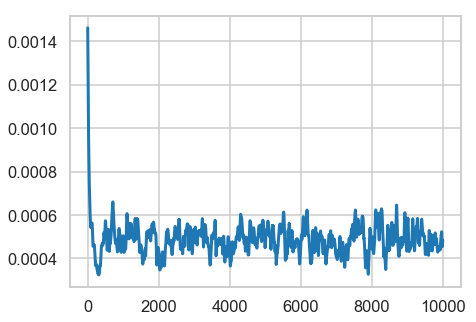

In [151]:
plt.plot(np.abs(diffs).mean(1)[1:])

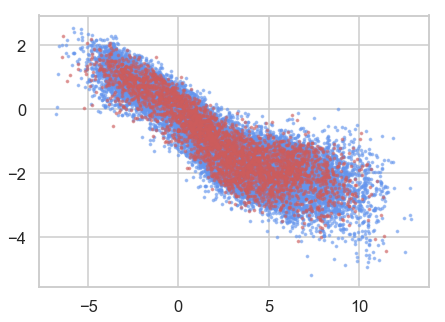

In [152]:
# Check what the network is learning
plt.scatter(features[::100], targets[::100], s=5, alpha=0.5, color='cornflowerblue');
plt.scatter(ol.all_features[::100], ol.all_targets[::100], s=5, alpha=0.5, color='indianred');

In [154]:
np.polyfit(ol.all_features, ol.all_targets, 1)

array([-0.31084436, -0.20933445])

Here we can see that the online targets are representative of the "true" targets.

In [155]:
# Check how the parameters
parameters = np.array(ol.parameter_history).squeeze(); parameters.shape

(10000, 2)

Text(0.5, 1.0, 'Online learning')

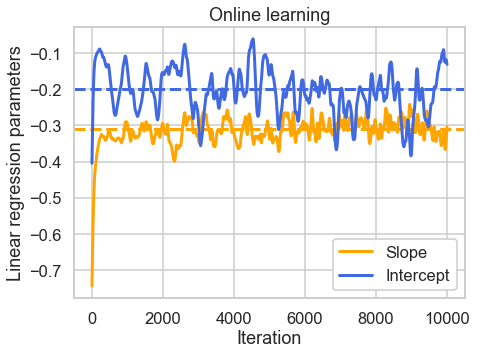

In [156]:
plt.plot(parameters[:, 0], c='orange', label='Slope')
plt.axhline(slope, c='orange', ls='--')
plt.plot(parameters[:, 1], c='royalblue', label='Intercept')
plt.axhline(intercept, c='royalblue', ls='--')
plt.xlabel('Iteration')
plt.ylabel('Linear regression parameters')
plt.legend(framealpha=1)
plt.title('Online learning')

So the algorithm works, but the results are rather jittery. This makes sense since we are updating every iteration with correlated samples. So the network is continuously pushed one way or another. One way to combat this might be to reduce the learning rate. Another though is to update only every few time steps, which we will do further below.

### CRM has smaller time step

This is a much more realistic setup. The forcing then is continuously applied as the CRM completes several time steps to catch up with one GCM time step.

In [157]:
# Load the "wrongly" pretrained model
lr_net = keras.models.load_model('./lr.h5')
lr_net.optimizer.lr = 0.001
ml_param = NNParam(lr_net)

In [158]:
# Create the two models
# This is the machine learning model. Either linear regression or a neural network
l96_ml = L96TwoLevel(parameterization=ml_param, X_init=initX, Y_init=initY, dt=0.01)
# This is the true model (aka the CRM) that will be nudged
l96_crm = L96TwoLevel(integration_type='uncoupled', X_init=initX, Y_init=initY, save_dt=0.001)

In [159]:
ol2 = OnlineLearning(l96_ml, l96_crm, dt_factor=10)

In [160]:
# This can now take a minute or two since the CRM has to do ten times as many steps
ol2.iterate(10000)

In [161]:
# Check how differences between the ML model and the "CRM" decrease
diffs = np.array(ol2.diff_history); diffs.shape

(10000, 36)

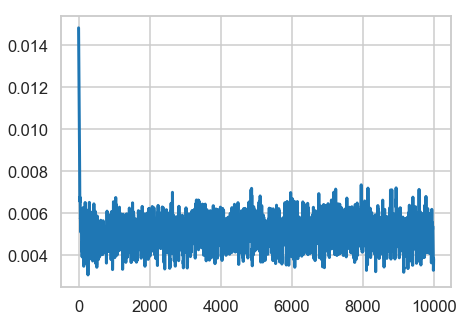

In [162]:
plt.plot(np.abs(diffs).mean(1)[1:])

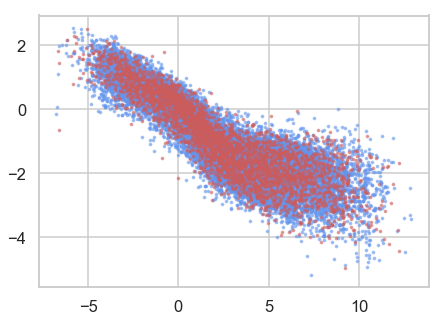

In [165]:
# Check what the network is learning
plt.scatter(features[::100], targets[::100], s=5, alpha=0.5, color='cornflowerblue');
plt.scatter(ol2.all_features[::100], ol2.all_targets[::100], s=5, alpha=0.5, color='indianred');

In [166]:
np.polyfit(ol2.all_features, ol2.all_targets, 1)

array([-0.30985427, -0.17055539])

Now what we can see is that the bias actually seems to be a little different from the "true" value. This might be because the assumption that the forcing and the CRM response are actually not linear superpositions. The differences are very small however.

In [167]:
# Check how the parameters
parameters = np.array(ol2.parameter_history).squeeze(); parameters.shape

(10000, 2)

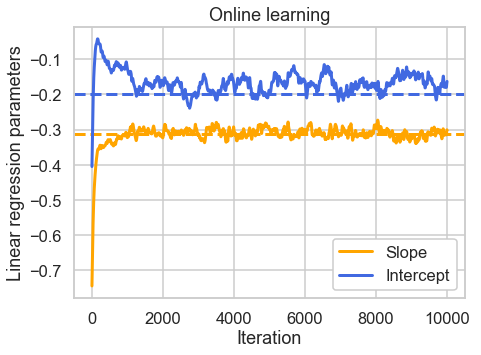

In [168]:
plt.plot(parameters[:, 0], c='orange', label='Slope')
plt.axhline(slope, c='orange', ls='--')
plt.plot(parameters[:, 1], c='royalblue', label='Intercept')
plt.axhline(intercept, c='royalblue', ls='--')
plt.xlabel('Iteration')
plt.ylabel('Linear regression parameters')
plt.legend(framealpha=1)
plt.title('Online learning');

The bias is still quite jittery.

### Updates every few time steps

We do not have to update every tim. In fact, we might not want to pull the ML parameterization too much to the actual state. Rather we can let the models run for a few time steps without a gradient descent step.

In [169]:
# Load the "wrongly" pretrained model
lr_net = keras.models.load_model('./lr.h5')
lr_net.optimizer.lr = 0.001
ml_param = NNParam(lr_net)

In [170]:
# Create the two models
# This is the machine learning model. Either linear regression or a neural network
l96_ml = L96TwoLevel(parameterization=ml_param, X_init=initX, Y_init=initY, dt=0.01)
# This is the true model (aka the CRM) that will be nudged
l96_crm = L96TwoLevel(integration_type='uncoupled', X_init=initX, Y_init=initY, save_dt=0.001)

In [171]:
ol3 = OnlineLearning(l96_ml, l96_crm, dt_factor=10, update_frequency=10)

In [172]:
# This can now take a minute or two since the CRM has to do ten times as many steps
ol3.iterate(10000)

In [173]:
# Check how differences between the ML model and the "CRM" decrease
diffs = np.array(ol3.diff_history); diffs.shape

(10000, 36)

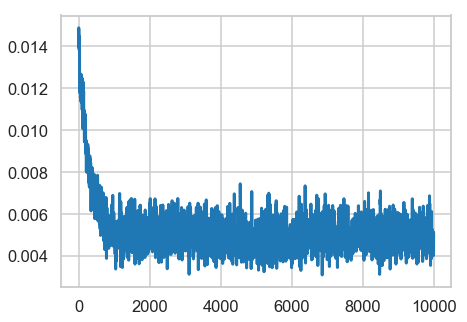

In [174]:
plt.plot(np.abs(diffs).mean(1)[1:])

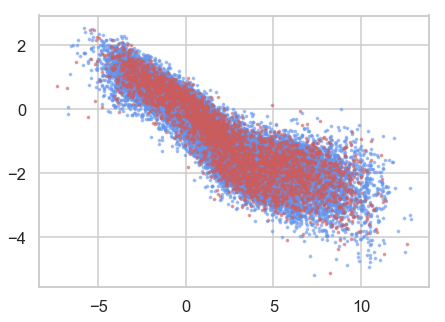

In [175]:
# Check what the network is learning
plt.scatter(features[::100], targets[::100], s=5, alpha=0.5, color='cornflowerblue');
plt.scatter(ol3.all_features[::100], ol3.all_targets[::100], s=5, alpha=0.5, color='indianred');

In [176]:
np.polyfit(ol3.all_features, ol3.all_targets, 1)

array([-0.3144859 , -0.15654533])

Note that the bias has changed a little further. This might be evidence that updating every few time steps makes some of the linearity assumptions a little less valid. But again, the difference is tiny.

In [177]:
# Check how the parameters
parameters = np.array(ol3.parameter_history).squeeze(); parameters.shape

(1000, 2)

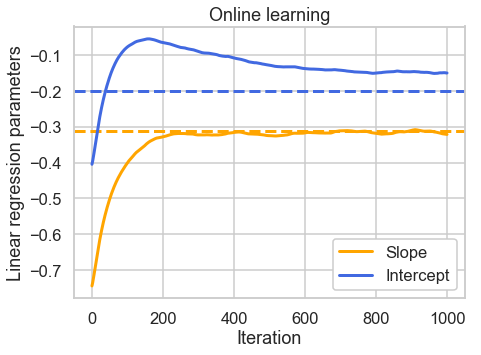

In [178]:
plt.plot(parameters[:, 0], c='orange', label='Slope')
plt.axhline(slope, c='orange', ls='--')
plt.plot(parameters[:, 1], c='royalblue', label='Intercept')
plt.axhline(intercept, c='royalblue', ls='--')
plt.xlabel('Iteration')
plt.ylabel('Linear regression parameters')
plt.legend(framealpha=1)
plt.title('Online learning');

This is now much smoother but, of course, we are only training 1/10th of the time. So we need more model iteration per ML update. Can we somehow get the best of both worlds?

### Off-policy learning

In [219]:
# Load the "wrongly" pretrained model
lr_net = keras.models.load_model('./lr.h5')
lr_net.optimizer.lr = 0.001
ml_param = NNParam(lr_net)

In [220]:
# Create the two models
# This is the machine learning model. Either linear regression or a neural network
l96_ml = L96TwoLevel(parameterization=ml_param, X_init=initX, Y_init=initY, dt=0.01)
# This is the true model (aka the CRM) that will be nudged
l96_crm = L96TwoLevel(integration_type='uncoupled', X_init=initX, Y_init=initY, save_dt=0.001)

In [221]:
ol4 = OnlineLearning(l96_ml, l96_crm, dt_factor=10, update_frequency=1, 
                     capacity=l96_ml.K * 1000, bs=1024)

In [222]:
# This of course takes longer now since we have several batches per update. 
# In a real CRM the gradient descent update would be insigificant compared to the CRM integration.
ol4.iterate(3000)

In [223]:
# Check how differences between the ML model and the "CRM" decrease
diffs = np.array(ol4.diff_history); diffs.shape

(3000, 36)

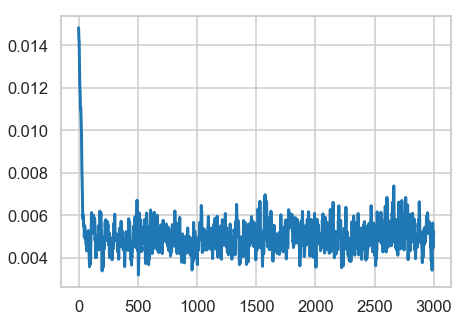

In [224]:
plt.plot(np.abs(diffs).mean(1)[1:])

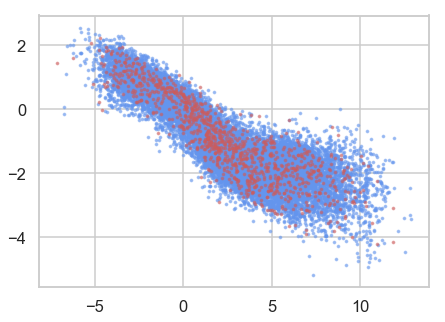

In [225]:
# Check what the network is learning
plt.scatter(features[::100], targets[::100], s=5, alpha=0.5, color='cornflowerblue');
plt.scatter(ol4.all_features[::100], ol4.all_targets[::100], s=5, alpha=0.5, color='indianred');

In [226]:
np.polyfit(ol4.all_features, ol4.all_targets, 1)

array([-0.31612631, -0.16740804])

Now what we can see is that the bias actually seems to be a little different from the "true" value. This might be because the assumption that the forcing and the CRM response are actually not linear superpositions. The differences are very small however.

In [227]:
# Check how the parameters
parameters = np.array(ol4.parameter_history).squeeze(); parameters.shape

(3000, 2)

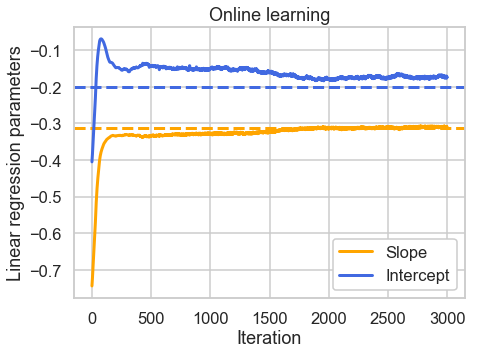

In [228]:
plt.plot(parameters[:, 0], c='orange', label='Slope')
plt.axhline(slope, c='orange', ls='--')
plt.plot(parameters[:, 1], c='royalblue', label='Intercept')
plt.axhline(intercept, c='royalblue', ls='--')
plt.xlabel('Iteration')
plt.ylabel('Linear regression parameters')
plt.legend(framealpha=1)
plt.title('Online learning');

So we already have very smooth convergence by 3000 CRM iterations where it was still far off in the previous setup. 

## Same with neural net

In [167]:
nnet = keras.models.Sequential([
    Dense(32, input_shape=(1,), activation='elu'),
    Dense(32, activation='elu'),
    Dense(1)
])

In [168]:
nnet.compile('adam', 'mse')

In [172]:
nnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [169]:
nnet.fit(features_wrong, targets_wrong, epochs=30, verbose=0)

In [171]:
nnet.save('./nn.h5')

In [180]:
# Load the "wrongly" pretrained model
#lr_net = keras.models.load_model('/project/meteo/w2w/A6/S.Rasp/tmp/lr.h5')
nnet = keras.models.load_model('./nn.h5')
ml_param = NNParam(nnet)

In [181]:
# Create the two models
# This is the machine learning model. Either linear regression or a neural network
l96_ml = L96TwoLevel(parameterization=ml_param, X_init=initX, Y_init=initY, save_dt=0.001)
# This is the true model (aka the CRM) that will be nudged
l96_crm = L96TwoLevel(integration_type='uncoupled', X_init=initX, Y_init=initY, save_dt=0.001)

In [182]:
ol = OnlineLearning(l96_ml, l96_crm, update_frequency=10, dt_factor=1)

In [183]:
ol.iterate(10000)

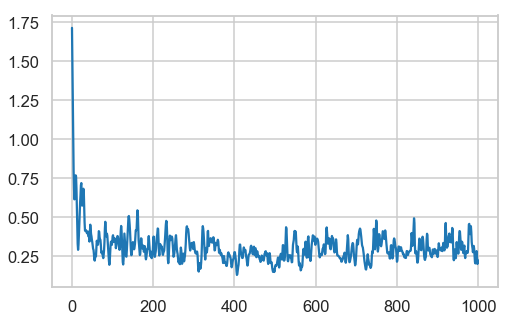

In [184]:
plt.plot(ol.loss_history)

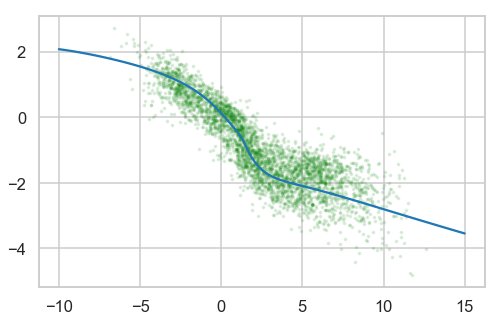

In [185]:
plt.scatter(features[::1000], targets[::1000], s=5, alpha=0.1, c='g');
tmp = np.linspace(-10, 15, 100)
plt.plot(tmp, nnet.predict(tmp))